In [2]:
import numpy as np
import scipy
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize

In [3]:
def calculate_stiffness_flexure(L, lmdb, gamma, E, t, b):
    ###### First set of equations corresponds to Leaf spring/flexure: Reinforced

    term_precompute = np.reciprocal(2 * lmdb * (1 - gamma) + gamma)

    # Stifness
    Cx = term_precompute * E * t * b / L # F / delta_x
    Cy = np.reciprocal(2 * lmdb * (4 * lmdb**2 - 6*lmdb + 3) * (1 - gamma) + gamma) * E * t * b**3 / 4 / L**3 # F / delta_y
    Cz = np.reciprocal(2 * lmdb * (4 * lmdb**2 - 6*lmdb + 3) * (1 - gamma**3) + gamma**3) * E * b * t**3 / 4 / L**3 # F / delta_z

    # Rotational stiffness
    Ky = np.reciprocal(2 * lmdb * (1 - gamma**3) + gamma**3) * E * b * t**3 / 12 / L # M / delta_theta_y
    Kz = term_precompute * E * t * b**3 / 12 / L # M / delta_theta_z
    
    return Cx, Cy, Cz, Ky, Kz

def calculate_stiffness_strut(Lp, lmdb, gamma, E, d):
    ###### Second set of equations corresponds Reinforced strut

    # Stifness
    Cx = np.reciprocal(gamma**2 + 2 * lmdb) * E * np.pi * d**2 / 4 / Lp # F / delta_x
    Cy = np.reciprocal(6*lmdb) * 3 * E * np.pi * d**4 / 16 / Lp**3 # F / delta_y
    Cz = Cy

    # Rotational stiffness
    Ky = np.reciprocal(2*lmdb) * E * np.pi * d**4 / 64 / Lp # M / delta_theta_y
    Kz = Ky

    return Cx, Cy, Cz, Ky, Kz

def calculate_stiffness_rod(L, E, I):
    ###### Third set of equations corresponds to Rod

    # Stifness
    Cx = 3 * E * I / L**3 # F / delta_x
    Cy = Cx # F / delta_y

    # Rotational stiffness
    Kx = E * I / L # M / delta_theta_x
    Ky = Kx # M / delta_theta_y

    return Cx, Cy, Kx, Ky

def calculate_stiffness_hollow_semicircular_annulus_thick(L, E, R_out, r_in, t):
    ###### Fourth set of equations corresponds to Hollow semicircular annulus with 
    # thickened rectangular element below

    # Area of the semicirular annulus
    A_semi = np.pi * (R_out**2 - r_in**2) / 2
    # Area of the rectangular base width 2R_out and height t
    A_rect = 2 * R_out * t

    # Area moment of inertia of the semicircular annulus
    I_semi = np.pi / 8 * (R_out**4 - r_in**4)
    # Area moment of inertia of the rectangular base
    I_rect_centroid = 1/12 * 2 * R_out * t**3
    # Parallel axis theorem to calculate I_rect about upper edge (base)
    I_rect = I_rect_centroid + A_rect * (t / 2)**2
    # Total area moment of inertia
    I_total = I_semi + I_rect

    # Stifness - in L direction for elongation E * A / L
    Cz = E / L * (A_semi + A_rect) # F / delta_x

    # Rotational stiffness
    # Ky = E / L * (np.pi / 8 * (R_out**4 - r_in**4) + 2 / 3 * R_out * t**3)  # M / delta_theta_y
    Ky = E / L * I_total # M / delta_theta_y

    return A_semi, A_rect, I_semi, I_rect, I_total, Cz, Ky

def compute_bellow_moment_force(p, R_outer, r_inner, n_bellow):
    """Approximate the total force and moment from the bellow structure. Approximate bellow
    structure area.

    Args:
        p (float): Pressure in Pa
        R_outer (float): Outer radius of the bellow in mm
        r_inner (float): Inner radius of the bellow in mm
        n_bellow (np.array): Number of bellows in the structure
    """
    # Reshape n_bellow to column vector
    n_bellow = n_bellow.reshape(-1, 1)
    # Effective area of a single bellow - hollow semicircle with radius R_outer and r_inner
    A_bellow = np.pi * (R_outer**2 - r_inner**2) / 2
    # Total force from bellow structure
    F_bellow = n_bellow * p * A_bellow
    # Total moment from bellow structure
    M_bellow = 2/3 * n_bellow * p * (R_outer**3 - r_inner**3)

    return A_bellow, F_bellow, M_bellow


#### Leaf spring/flexure: Reinforced

In [7]:
# Young's modulus for TPU 85A in Mpa
E = 27
# Length of the entire segment in mm
L = 31
# Unreinforced length in mm
Ls = 1
# Thickness in z-direction in mm - reinforced and unreinforced
# t = 2.5
t = 10
# T = 4.7
T = 22
# Thickness in y direction in mm
b1 = 12 # finger articulated surface dimension
b2 = 20 # Inner thicker part dimensions
b = (b1 + 2*b2) / 3 # average thickness this way
# Design parameters
lmdb = Ls / L
gamma = t / T

Cx, Cy, Cz, Ky, Kz = calculate_stiffness_flexure(L, lmdb, gamma, E, t, b)

In [8]:
(T+T)/2 * b

381.3333333333333

In [9]:
# Print all dimensions and design parameters
print("Lengths")
print(f'L = {L} mm')
print(f'Ls = {Ls} mm')
print('Thickness')
print(f't = {t} mm')
print(f'T = {T} mm')
print(f'b = {b} mm')
print("Design Parameters")
print(f'lmdb = {lmdb}')
print(f'gamma = {gamma}')
print('Material Properties')
print(f'E = {E} MPa')
# Print all lengths
# Print all stifness values
np.set_printoptions(threshold=np.inf)
print("Stiffness")
print(f'Cx = {Cx} N/mm')
print(f'Cy = {Cy} N/mm')
print(f'Cz = {Cz} N/mm')
print('Rotational Stiffness')
print(f'Ky = {Ky} Nmm/rad')
print(f'Kz = {Kz} Nmm/rad')

Lengths
L = 31 mm
Ls = 1 mm
Thickness
t = 10 mm
T = 22 mm
b = 17.333333333333332 mm
Design Parameters
lmdb = 0.03225806451612903
gamma = 0.45454545454545453
Material Properties
E = 27 MPa
Stiffness
Cx = 308.2634730538922 N/mm
Cy = 21.319865245606966 N/mm
Cz = 15.209665067405616 N/mm
Rotational Stiffness
Ky = 8256.561157944967 Nmm/rad
Kz = 7718.003992015966 Nmm/rad


#### Reinforced strut

In [3]:
# Young's modulus for TPU 85A in Mpa
E = 27
# Length of all three ribbed segments in mm
L0 = np.array([31, 20.5, 20.5])
# Unreinforced and reinforced length in mm
l_unreinforced = 2
L_reiforced = L0 - 2 * l_unreinforced
# Diameters in mm - reinforced and unreinforced
d_hole = 6
D_rib_out = 22
d_rib_in = 7.85
# Thickness of the bottom element
t_in = 2.5
T_out = 4.7
b_in = 12
b_out = 20
# Area of bottom element - approximate
A_bottom = (b_in + 2 * b_out) / 3 * (t_in + T_out) / 2
# Area of inner rib around hole
A_rib_in = (d_rib_in**2 - d_hole**2) * np.pi / 4
d_unreinforced = np.sqrt((A_bottom + A_rib_in) / np.pi * 4)
# Equivalent diameter to keep the same surface area of reinforced part
D_reinforced = np.sqrt((D_rib_out**2 - d_hole**2))
# Design parameters
Lp = L_reiforced + l_unreinforced
lmdb = l_unreinforced / Lp
gamma = d_unreinforced / D_reinforced

Cx, Cy, Cz, Ky, Kz = calculate_stiffness_strut(Lp, lmdb, gamma, E, d_unreinforced)

# Print all dimensions and design parameters
print("Lengths")
print(f'L0 = {L0} mm')
print(f'l_unreinforced = {l_unreinforced} mm')
print(f'L_reiforced = {L_reiforced} mm')
print(f'Lp = {Lp} mm')
print('Diameters')
print(f'd_unreinforced = {d_unreinforced} mm')
print(f'D_reinforced = {D_reinforced} mm')
print('Areas')
print(f'A_unreinforced = {np.pi * d_unreinforced**2 / 4} mm^2')
print(f'A_reinforced = {np.pi * D_reinforced**2 / 4} mm^2')
print("Design Parameters")
print(f'lmdb = {lmdb}')
print(f'gamma = {gamma}')
print('Material Properties')
print(f'E = {E} MPa')
print("Stiffness")
print(f'Cx = {Cx} N/mm')
print(f'Cy = {Cy} N/mm')
print(f'Cz = {Cz} N/mm')
print('Rotational Stiffness')
print(f'Ky = {Ky} Nmm/rad')
print(f'Kz = {Kz} Nmm/rad')

Lengths
L0 = [31.  20.5 20.5] mm
l_unreinforced = 2 mm
L_reiforced = [27.  16.5 16.5] mm
Lp = [29.  18.5 18.5] mm
Diameters
d_unreinforced = 10.250494992510076 mm
D_reinforced = 21.166010488516726 mm
Areas
A_unreinforced = 82.5238644416511 mm^2
A_reinforced = 351.8583772020569 mm^2
Design Parameters
lmdb = [0.06896552 0.10810811 0.10810811]
gamma = 0.48429036724097413
Material Properties
E = 27 MPa
Stiffness
Cx = [206.27952836 267.19763178 267.19763178] N/mm
Cy = [17.39870876 42.75329164 42.75329164] N/mm
Cz = [17.39870876 42.75329164 42.75329164] N/mm
Rotational Stiffness
Ky = [3658.07851581 3658.07851581 3658.07851581] Nmm/rad
Kz = [3658.07851581 3658.07851581 3658.07851581] Nmm/rad


#### Rod Spring

In [9]:
# Young's modulus for TPU 85A in Mpa
E = 27
# Length of all three ribbed segments in mm
L0 = np.array([31, 20.5, 20.5])
# Diameters in mm - reinforced and unreinforced
d_hole = 6
D_rib_out = 22
d_rib_in = 7.85
# Equivalent diameter to reduce the cross-section surface area - not full material
# Use lmbd as a mixing parameter betweeen D_rib_out and d_rib_in
lmbd = np.array([1.0, 0.7, 0.7])
D_rib_out_equivalent = D_rib_out * lmbd + d_rib_in  * (1 - lmbd)
# Area of the tube
A_tube = np.pi / 4 * (D_rib_out_equivalent**2 - d_hole**2)
# Area moment of inertia
I_tube = np.pi / 64 * (D_rib_out_equivalent**4 - d_hole**4)
# I_tube = np.pi / 64 * (D_rib_out_equivalent**4 - d_rib_in**4)
# D_ros_equivalent = np.sqrt((D_rib_out**2 - d_hole**2))

Cx, Cy, Kx, Ky = calculate_stiffness_rod(L0, E, I_tube)

# Print all dimensions and design parameters
print("Lengths")
print(f'L0 = {L0} mm')
print('Diameters')
print(f'D_rib_out = {D_rib_out} mm')
print(f'd_rib_in = {d_rib_in} mm')
print(f'd_hole = {d_hole} mm')
print(f'D_rib_out_equivalent = {D_rib_out_equivalent} mm')
print('Areas')
print(f'A_tube = {A_tube} mm^2')
print('Area moment of inertia')
print(f'I_tube = {I_tube} mm^4')
print('Material Properties')
print(f'E = {E} MPa')
print("Stiffness")
print(f'Cx = {Cx} N/mm')
print(f'Cy = {Cy} N/mm')
print('Rotational Stiffness')
print(f'Kx = {Kx} Nmm/rad')
print(f'Ky = {Ky} Nmm/rad')

Lengths
L0 = [31.  20.5 20.5] mm
Diameters
D_rib_out = 22 mm
d_rib_in = 7.85 mm
d_hole = 6 mm
D_rib_out_equivalent = [22.    17.755 17.755] mm
Areas
A_tube = [351.8583772  219.31460278 219.31460278] mm^2
Area moment of inertia
I_tube = [11435.39725907  4814.50416025  4814.50416025] mm^4
Material Properties
E = 27 MPa
Stiffness
Cx = [31.09218146 45.26630049 45.26630049] N/mm
Cy = [31.09218146 45.26630049 45.26630049] N/mm
Rotational Stiffness
Kx = [9959.86212886 6341.05425984 6341.05425984] Nmm/rad
Ky = [9959.86212886 6341.05425984 6341.05425984] Nmm/rad


#### Optimization for fixed-free beam bending with end force

In [4]:
# Young's modulus for TPU 85A in Mpa
E = 27
# Length of all three bellow segments in mm
L0 = np.array([31, 21, 21])
# Diameters in mm - reinforced and unreinforced
d_hole = 6
D_bellow_out = 22
d_bellow_in = 7.85
# Thickness of bottom layer in mm
t = 2.5

pressure = np.linspace(0, 0.3, 8)  # Internal pressure (MPa)
# Remove thickness of the bellow from R_outer, and add it to r_inner (+0.9 due to geometry)
R_outer = 15.5 - 0.8  # Outer diameter of bellow (mm) - 15.5 is from thick element to top
r_inner = d_bellow_in + 0.575  # Inner diameter of bellow (mm)
n_bellow = np.array([7, 5, 5])  # Number of bellows

# Load experimental data
experiment_data = pd.read_csv('kinematics/Hand9DOF/Index/data/soft_robot_experiment_results.csv')
# Extract only index finger delta_z exparimental
delta_z_exp = experiment_data[experiment_data['finger'] == 'index'].dropna()[['d_1_3', 'd_3_5', 'd_5_7']].values.T
delta_theta_y_exp_rep1 = experiment_data.loc[(experiment_data['finger'] == 'index') & (experiment_data['rep'] == 1)][['theta2', 'theta4', 'theta6']].values.T
delta_theta_y_exp_rep2 = experiment_data.loc[(experiment_data['finger'] == 'index') & (experiment_data['rep'] == 2)][['theta2', 'theta4', 'theta6']].values.T

def compute_angle_displacement_mase(
    lmbd, gamma, p, R_outer, r_inner, n_bellow, L0, E, d_hole, D_bellow_out, d_bellow_in, t,
    delta_z_exp, delta_theta_y_exp_rep1, delta_theta_y_exp_rep2
    ):
    # Compute single bellow area, force and moment
    A_bellow, F_bellow, M_bellow = compute_bellow_moment_force(p*gamma, R_outer, r_inner, n_bellow)
    # Calculate equivalent diameter
    D_bellow_out_equivalent = lmbd * D_bellow_out + (1 - lmbd) * d_bellow_in
    # Calculate stiffness
    _, _, _, _, _, Cz, Ky = calculate_stiffness_hollow_semicircular_annulus_thick(
        L0, E, D_bellow_out_equivalent / 2, d_hole / 2, t
        )
    # Compute elongation
    delta_z = F_bellow / Cz[:, np.newaxis] 
    # Calculate angle displacement
    delta_theta_y = M_bellow / Ky[:, np.newaxis] * 180 / np.pi
    # Calculate mean absolute  standardized error
    delta_z_mae = np.mean(np.abs(delta_z_exp - delta_z))
    delta_z_mae_mean = np.mean(np.abs(delta_z_exp - np.mean(delta_z_exp)))
    delta_z_mase = delta_z_mae / delta_z_mae_mean
    delta_theta_y_ae_rep1 = np.abs(delta_theta_y - delta_theta_y_exp_rep1)
    delta_theta_y_ae_mean_rep1 = np.abs(delta_theta_y_exp_rep1 - np.mean(delta_theta_y_exp_rep1))
    delta_theta_y_ae_rep2 = np.abs(delta_theta_y - delta_theta_y_exp_rep2)
    delta_theta_y_ae_mean_rep2 = np.abs(delta_theta_y_exp_rep2 - np.mean(delta_theta_y_exp_rep2))
    delta_theta_y_mae = np.mean(np.vstack((delta_theta_y_ae_rep1, delta_theta_y_ae_rep2)))
    delta_theta_y_mae_mean = np.mean(np.vstack((delta_theta_y_ae_mean_rep1, delta_theta_y_ae_mean_rep2)))
    delta_theta_y_mase = delta_theta_y_mae / delta_theta_y_mae_mean
    return delta_z_mase, delta_theta_y_mase

def obj_func_single_param(x):
    # print(x)
    lmbd = x[[0, 1, 1]]
    gamma = x[2:].reshape(-1, 1)
    delta_z_mase, delta_theta_y_mase = compute_angle_displacement_mase(
        lmbd, gamma, pressure, R_outer, r_inner, n_bellow, L0, E, d_hole, D_bellow_out, d_bellow_in, t,
        delta_z_exp, delta_theta_y_exp_rep1, delta_theta_y_exp_rep2
        )
    # print(delta_z_mase)
    # print(delta_theta_y_mase)
    # Return mean of the two errors
    # print((delta_z_mae + delta_theta_y_mae) / 2)
    return (delta_z_mase + delta_theta_y_mase) / 2

obj_func_single_param(np.array([0.65, 0.65, 1.0, 1.0, 1.0]))


optim_res = scipy.optimize.brute(
    func=obj_func_single_param,
    ranges=(
        # lambda range from 0.2 to 0.9 with step 0.05,
        slice(0.5, 0.98, 0.04), slice(0.5, 0.9, 0.04),
        # gamma from 0.6 to 1.4 with step 0.05
        slice(0.6, 1.6, 0.04), slice(0.6, 1.6, 0.04), slice(0.6, 2., 0.04)),
    full_output=True,
    finish=None,
    workers=-1
    )
# Plot only parameters and objective function value
optim_res[:2]

(array([0.94, 0.74, 1.36, 1.44, 1.96]), 0.5583904222587684)

#### Hollow Semicircular Annulus and rectangular base

In [5]:
# Young's modulus for TPU 85A in Mpa
E = 27
# Length of all three bellow segments in mm
L0 = np.array([31, 21, 21])
# Diameters in mm - reinforced and unreinforced
d_hole = 6
D_bellow_out = 22
d_bellow_in = 7.85
# Thickness of bottom layer in mm
t = 2.5
# Equivalent diameter to reduce the cross-section surface area - not full material
# Use lmbd as a mixing parameter betweeen D_bellow_out and d_bellow_in
lmbd = np.array([0.94, 0.74, 0.74]) # Works for maximum pressure of 3 bar
# lmbd = 0.65
D_bellow_out_equivalent = lmbd * D_bellow_out + (1 - lmbd) * d_bellow_in

# Area of the semicirular annulus
# Area of the rectangular base width D_bellow_out_equivalent and height t
# Area moment of inertia of the semicircular annulus
# Area moment of inertia of the rectangular base
# Parallel axis theorem to calculate I_rect about upper edge (base)
# Total area moment of inertia
# Rotational stifness about y-axis
A_semi, A_rect, I_semi, I_rect, I_total, Cz, Ky = calculate_stiffness_hollow_semicircular_annulus_thick(
    L0, E, D_bellow_out_equivalent / 2, d_hole / 2, t
    )

# Print all dimensions and design parameters
print("Lengths")
print(f'L0 = {L0} mm')
print('Diameters')
print(f'D_bellow_out = {D_bellow_out} mm')
print(f'd_bellow_in = {d_bellow_in} mm')
print(f'd_hole = {d_hole} mm')
print('Thickness')
print(f't = {t} mm')
print('Equivalent Parameters')
print(f'lambda = {lmbd}')
print(f'D_bellow_out_equivalent = {D_bellow_out_equivalent} mm')
print('Areas')
print(f'A_semi = {A_semi} mm^2')
print(f'A_rect = {A_rect} mm^2')
print('Area moment of inertia')
print(f'I_semi = {I_semi} mm^4')
print(f'I_rect = {I_rect} mm^4')
print(f'I_total = {I_total} mm^4')
print('Material Properties')
print(f'E = {E} MPa')
print("Stiffness")
print(f'Cz = {Cz} N/mm')
print('Rotational Stiffness')
print(f'Ky = {Ky} Nmm/rad')

Lengths
L0 = [31 21 21] mm
Diameters
D_bellow_out = 22 mm
d_bellow_in = 7.85 mm
d_hole = 6 mm
Thickness
t = 2.5 mm
Equivalent Parameters
lambda = [0.94 0.74 0.74]
D_bellow_out_equivalent = [21.151 18.321 18.321] mm
Areas
A_semi = [161.5425796  117.67583022 117.67583022] mm^2
A_rect = [52.8775 45.8025 45.8025] mm^2
Area moment of inertia
I_semi = [4880.24980246 2733.45538811 2733.45538811] mm^4
I_rect = [110.16145833  95.421875    95.421875  ] mm^4
I_total = [4990.4112608  2828.87726311 2828.87726311] mm^4
Material Properties
E = 27 MPa
Stiffness
Cz = [186.75297255 210.18642457 210.18642457] N/mm
Rotational Stiffness
Ky = [4346.48722714 3637.12790971 3637.12790971] Nmm/rad


#### Bending moment and axial force approximation from pressure

In [12]:
pressure = np.linspace(0, 0.3, 8)  # Internal pressure (MPa)
# Remove thickness of the bellow from R_outer, and add it to r_inner (+0.9 due to geometry)
R_outer = 15.5 - 0.8  # Outer diameter of bellow (mm) - 15.5 is from thick element to top
r_inner = d_bellow_in + 0.575  # Inner diameter of bellow (mm)
n_bellow = np.array([7, 5, 5])  # Number of bellows
gamma = np.array([1.36 , 1.44 , 1.96])[:, np.newaxis] # Pressure adjustment
pressure_adj = pressure * gamma


print(f'pressure p = {pressure} MPa')
print(f'R_outer = {R_outer} mm')
print(f'r_inner = {r_inner} mm')
print(f'n_bellow: {n_bellow}')
A_bellow, F_bellow, M_bellow = compute_bellow_moment_force(pressure_adj, R_outer, r_inner, n_bellow)
print(f"A_bellow = {A_bellow} mm^2")
print('F_bellow [N]')
print(F_bellow)
print("M_bellow [Nmm]")
print(M_bellow)

pressure p = [0.         0.04285714 0.08571429 0.12857143 0.17142857 0.21428571
 0.25714286 0.3       ] MPa
R_outer = 14.7 mm
r_inner = 8.424999999999999 mm
n_bellow: [7 5 5]
A_bellow = 227.9372732335032 mm^2
F_bellow [N]
[[  0.          92.99840748 185.99681496 278.99522244 371.99362992
  464.9920374  557.99044488 650.98885235]
 [  0.          70.33493003 140.66986005 211.00479008 281.33972011
  351.67465013 422.00958016 492.34451018]
 [  0.          95.73365476 191.46730952 287.20096427 382.93461903
  478.66827379 574.40192855 670.13558331]]
M_bellow [Nmm]
[[   0.          701.35505575 1402.7101115  2104.06516725 2805.420223
  3506.77527875 4208.1303345  4909.48539025]
 [   0.          530.43659679 1060.87319357 1591.30979036 2121.74638714
  2652.18298393 3182.61958071 3713.0561775 ]
 [   0.          721.98314562 1443.96629125 2165.94943687 2887.9325825
  3609.91572812 4331.89887375 5053.88201937]]


[4346.48722714 3637.12790971 3637.12790971]


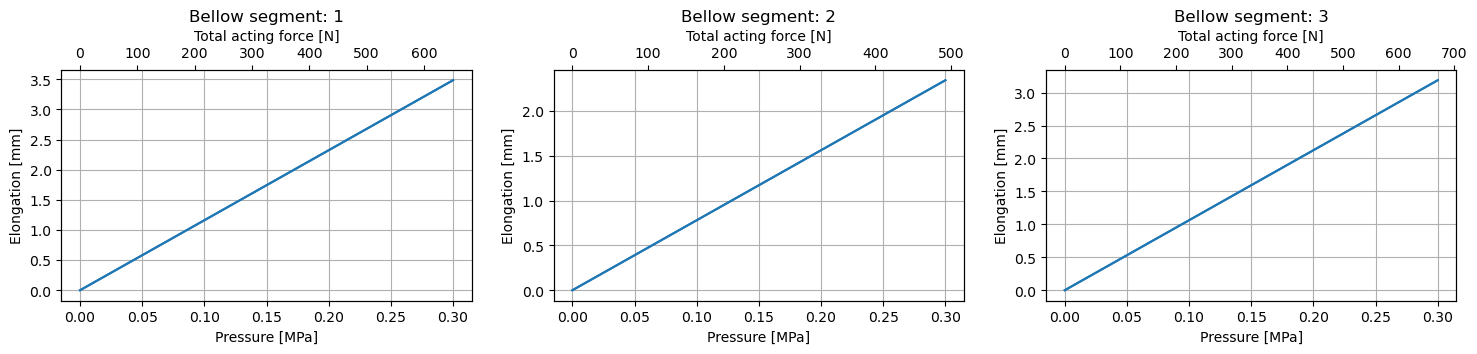

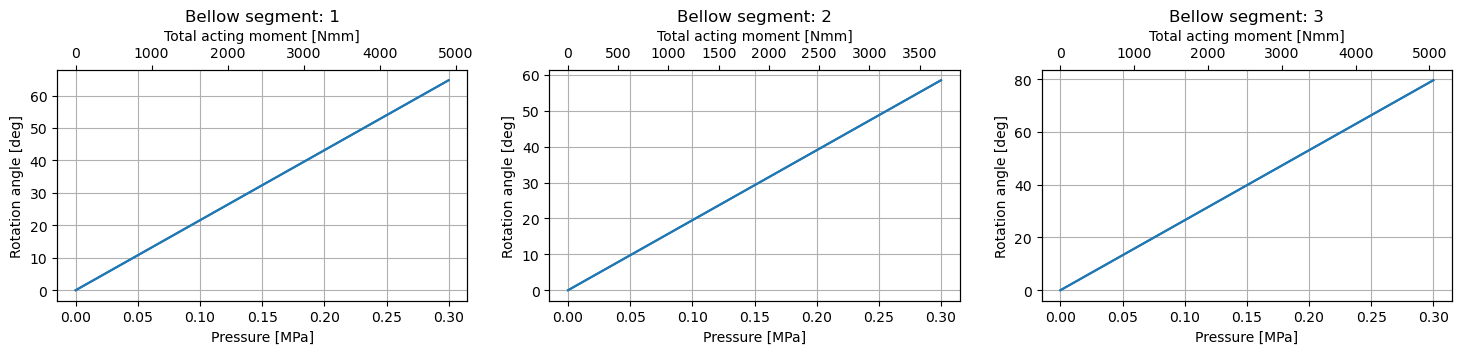

In [13]:
delta_z = F_bellow / Cz[:, np.newaxis] 
delta_theta_y = M_bellow / Ky[:, np.newaxis]
print(Ky)
# All angular deformations for subsequent segments are culumative sum cross columns
delta_theta_y_cum = np.cumsum(delta_theta_y, axis=0)

# Plot all elongations vs input pressure
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 3))
for i in range(3):
    ax[i].plot(pressure, delta_z[i, :])
    ax[i].set_xlabel('Pressure [MPa]')
    ax[i].set_ylabel('Elongation [mm]')
    ax[i].set_title(f'Bellow segment: {i+1}')
    # Add twin x axis showing input force
    ax2 = ax[i].twiny()
    ax2.plot(F_bellow[i, :], delta_z[i, :])
    ax2.set_xlabel('Total acting force [N]')
    ax[i].grid()

# Plot all rotation angles ve input pressure
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 3))
for i in range(3):
    ax[i].plot(pressure, delta_theta_y[i, :] * 180 / np.pi)
    ax[i].set_xlabel('Pressure [MPa]')
    ax[i].set_ylabel('Rotation angle [deg]')
    ax[i].set_title(f'Bellow segment: {i+1}')
    # Add twin x axis showing imput moment
    ax2 = ax[i].twiny()
    ax2.plot(M_bellow[i, :], delta_theta_y[i, :] * 180 / np.pi)
    ax2.set_xlabel('Total acting moment [Nmm]')
    ax[i].grid()

# # Plot peressure vs angular deformation in polar plot
# fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5), subplot_kw=dict(polar=True))
# for i in range(3):
#     ax.plot(delta_theta_y[i, :], p, label = f'Segment {i+1}')
#     ax.set_xlabel('Rotation angle [rad]')
#     ax.set_ylabel('Pressure [MPa]')
#     ax.legend()

# # Plot cumulative rotation angles
# fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(18, 3))
# for i in range(3):
#     ax[i].plot(p, delta_theta_y_cum[i, :] * 180 / np.pi, label=f'Segment {i+1}')
#     ax[i].set_xlabel('Pressure [MPa]')
#     ax[i].set_ylabel('Rotation angle [deg]')
#     # Add twin x axis showing imput moment
#     ax2 = ax[i].twiny()
#     ax2.plot(M_bellow[i, :], delta_theta_y_cum[i, :] * 180 / np.pi)
#     ax2.set_xlabel('Total acting moment [Nmm]')
#     ax[i].grid()

# # Plot peressure vs cumulative angular deformation in polar plot
# fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5, 5), subplot_kw=dict(polar=True))
# for i in range(3):
#     ax.plot(delta_theta_y_cum[i, :], p, label = f'Segment {i+1}')
#     ax.set_xlabel('Rotation angle [rad]')
#     ax.set_ylabel('Pressure [MPa]')
#     ax.legend()

In [11]:
print(delta_theta_y * 180 / np.pi)
print(delta_theta_y_cum * 180 / np.pi)
print(delta_z)

[[ 0.          9.24532445 18.4906489  27.73597335 36.9812978  46.22662225
  55.4719467  64.71727115]
 [ 0.          8.35598281 16.71196562 25.06794843 33.42393124 41.77991406
  50.13589687 58.49187968]
 [ 0.         11.37342105 22.7468421  34.12026315 45.49368419 56.86710524
  68.24052629 79.61394734]]
[[  0.           9.24532445  18.4906489   27.73597335  36.9812978
   46.22662225  55.4719467   64.71727115]
 [  0.          17.60130726  35.20261452  52.80392178  70.40522905
   88.00653631 105.60784357 123.20915083]
 [  0.          28.97472831  57.94945662  86.92418493 115.89891324
  144.87364155 173.84836986 202.82309817]]
[[0.         0.49797551 0.99595103 1.49392654 1.99190206 2.48987757
  2.98785308 3.4858286 ]
 [0.         0.33463117 0.66926235 1.00389352 1.3385247  1.67315587
  2.00778704 2.34241822]
 [0.         0.45547021 0.91094042 1.36641063 1.82188084 2.27735105
  2.73282125 3.18829146]]


Text(0.5, 1.0, 'All bellow segments')

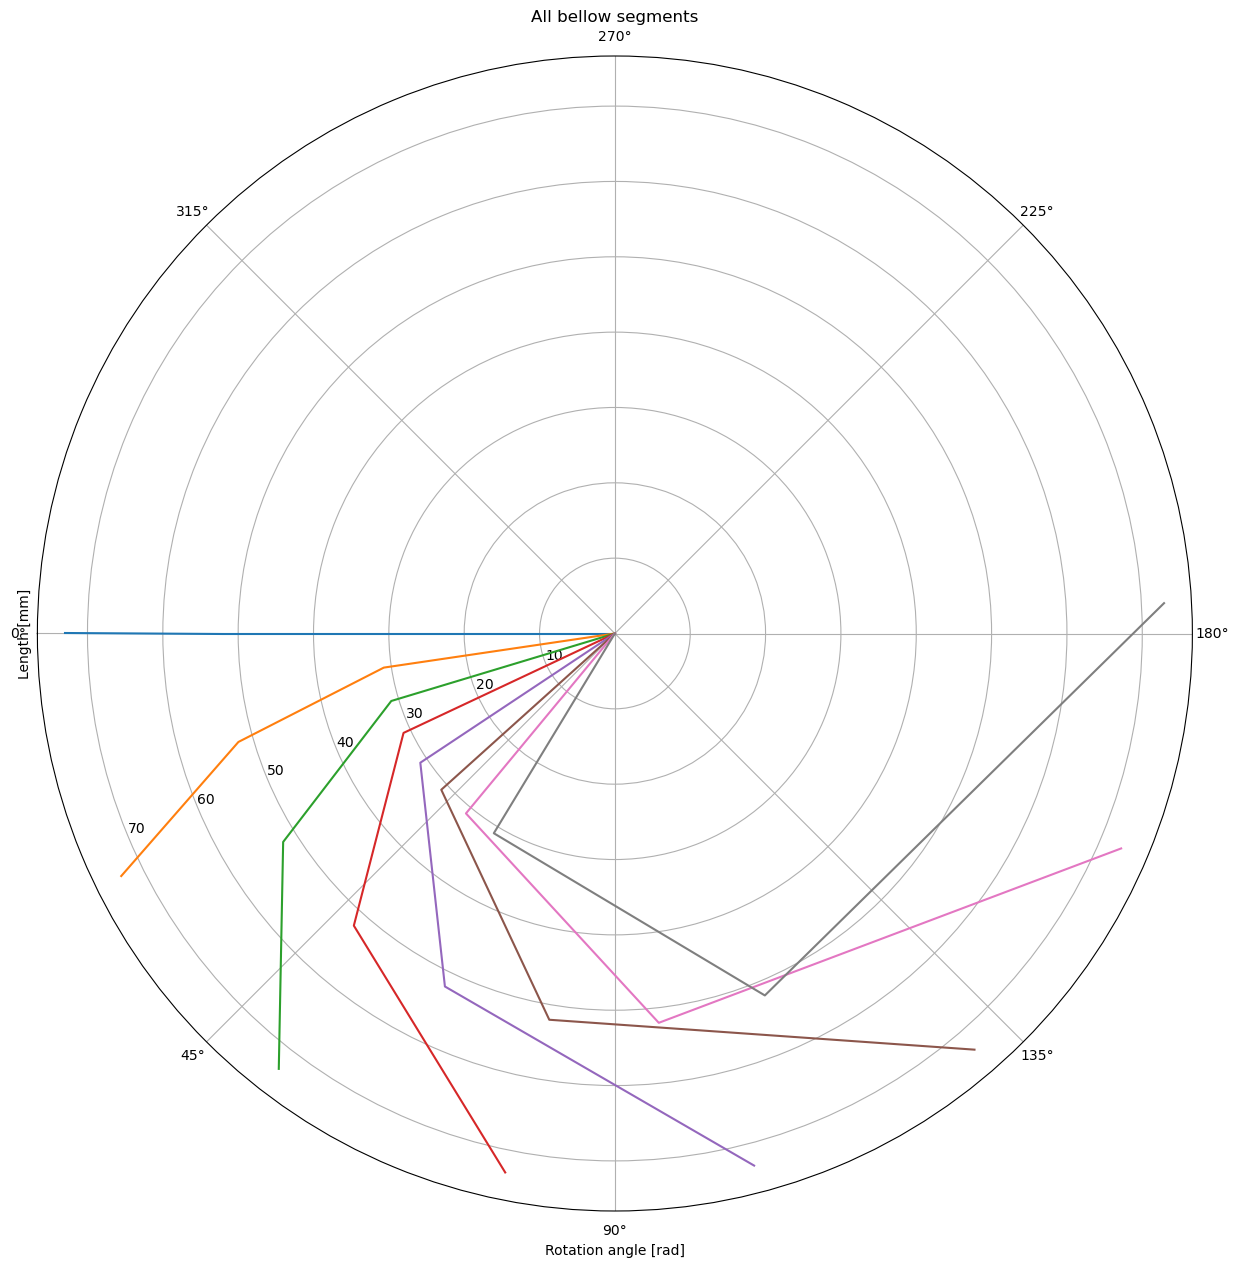

In [110]:
# All lenghts are cumulative sum of previous segments
L0_cum = np.cumsum(L0)
# Insert 0 angle row to the beginning of theta_y_cum and 0 length to the beginning of L0_cum
delta_theta_y_cum_plt = np.insert(delta_theta_y_cum, 0, 0, axis=0)
L0_cum_plt = np.insert(L0_cum, 0, 0, axis=0)

# Plot actual actuator segments in polar plot
# Plot link legment lengths L0 vs delta_theta_y
fig, ax = plt.subplots(figsize=(15, 15), subplot_kw=dict(polar=True))
# Set theta zero location to west
ax.set_theta_zero_location('W')
ax.plot(delta_theta_y_cum_plt, L0_cum_plt[:, np.newaxis])
ax.set_xlabel('Rotation angle [rad]')
ax.set_ylabel('Length [mm]')
ax.set_title('All bellow segments')